In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
os.environ['CLMM_MODELING_BACKEND'] = 'ccl' # here you may choose ccl or nc (NumCosmo)
sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMM/examples/support')
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import clmm.polaraveraging as pa
import clmm.galaxycluster as gc
import clmm.modeling as modeling
from clmm import Cosmology 
import numpy as np
import pyccl as ccl
import numpy as np
import sys
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from scipy.integrate import quad,simps, dblquad

In [2]:
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling')
import miscentering as mis
import two_halo_term as twoh

In [3]:
from cluster_toolkit import miscentering
from cluster_toolkit import deltasigma

In [4]:
import cluster_toolkit as ct

In [5]:
cluster_m = 7e14
cluster_z = 0.5
concentration = 5
moo = clmm.Modeling(massdef = 'mean', delta_mdef = 200, halo_profile_model = 'nfw')
mock_cosmo = Cosmology(H0=70.0, Omega_dm0=0.27-0.045, Omega_b0=0.045, Omega_k0=0.0)
cosmo_ccl = ccl.Cosmology(Omega_c=0.27-0.045, Omega_b=0.045, h=0.7, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)
moo.set_cosmo(mock_cosmo)
moo.set_mass(cluster_m) 
moo.set_concentration(concentration)

### Compute Miscentering

In [6]:
R_real = np.logspace(np.log10(0.1), np.log10(10), 10)
R_Sigma = np.logspace(np.log10(0.0001), np.log10(20), 500)

In [7]:
Sigma_nfw_clmm = moo.eval_sigma(R_Sigma, cluster_z) #Msun/Mpc^2 real

In [8]:
Rmis = 0.1
ds_mis_rayleigh =  mis.predict_sigma_excess_miscentering(Sigma_nfw_clmm, R_real, R_Sigma, Rmis, cluster_z, "rayleigh", moo)
ds_mis_gamma =  mis.predict_sigma_excess_miscentering(Sigma_nfw_clmm, R_real, R_Sigma, Rmis, cluster_z, "gamma", moo)

In [9]:
ds_mis = ds_mis_gamma

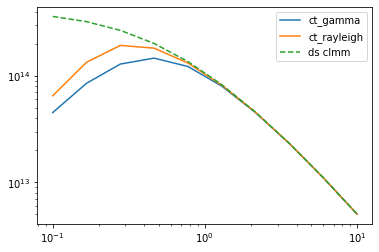

In [10]:
plt.loglog(R_real,ds_mis_gamma,'-',label = 'ct_gamma')
plt.loglog(R_real,ds_mis_rayleigh,'-',label = 'ct_rayleigh')
plt.plot(R_real, moo.eval_sigma_excess(R_real, cluster_z), '--', label = 'ds clmm')
plt.legend()

### Computing Power spectrum for 2h term

In [17]:
kk = np.logspace(-12,np.log10 (15) ,10000)

In [18]:
moo = clmm.Modeling(massdef = 'mean', delta_mdef = 200, halo_profile_model = 'nfw')
moo.set_cosmo(mock_cosmo)
moo.set_mass(cluster_m) 
moo.set_concentration(concentration)

In [19]:
R = R_real

In [20]:
Pk = twoh.compute_Pk(kk, cluster_z, cosmo_ccl)

In [21]:
ds_unbaised = twoh.two_halo_term_unbaised(R, cluster_z, cosmo_ccl, kk, Pk)
bais = twoh.halo_bais(logm = np.log10(cluster_m), mdef = 'matter', Delta = 200, cluster_z = cluster_z, cosmo_ccl = cosmo_ccl)

/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/two_halo_term.py:71: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  val = quad(integrand  , 2*1e-4 , 20000 , args = ( theta ))[0]
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/two_halo_term.py:71: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val = quad(integrand  , 2*1e-4 , 20000 , args = ( theta ))[0]


(0.1, 10.0)

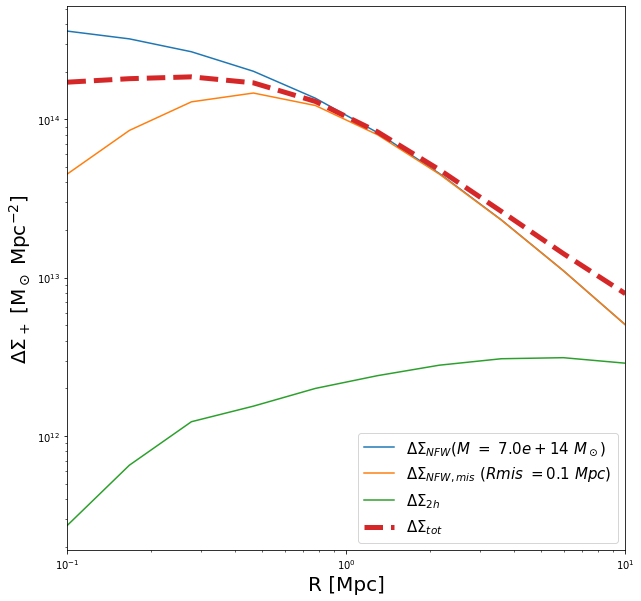

In [23]:
plt.figure(figsize = (10,10))
plt.loglog(R,moo.eval_sigma_excess(R,cluster_z), '-', label = r'$\Delta\Sigma_{NFW}$' + f'$(M\ =\ {cluster_m:.1e}\ M_\odot)$')
plt.loglog(R,ds_mis, '-', label = r'$\Delta\Sigma_{NFW, mis}$ ' + f'$(Rmis\ = {Rmis}\ Mpc)$')
plt.loglog(R,ds_unbaised*bais, '-', label = r'$\Delta\Sigma_{2h}$')
plt.plot(R, ds_unbaised*bais + 0.6*ds_mis + (1-0.6)*moo.eval_sigma_excess(R_real, cluster_z),'--',linewidth=5,label = r'$\Delta\Sigma_{tot}$')
plt.xlabel('R [Mpc]', fontsize = 20)
plt.ylabel(r'$\Delta\Sigma_+$ ' +'$[$' + r'${\rm M}$' + r'$_\odot\;$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$', fontsize = 20)
plt.legend(fontsize = 15)
plt.xlim(min(R),max(R))
#plt.savefig('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/examples/modelingillustration', dpi = 300)